In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import torch
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [137]:
plot_dir = '../plots/plots_2023-03-02_figures'
savefigs = True

Eventually should run this in scripts and save, but doing test set predictions in notebook for now

In [2]:
sim_name = 'TNG100-1'
#sim_name = 'TNG50-4'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = ''
geo_tag = ''
scalar_tag = ''
mass_multiplier = 1e10
log_mass_shift = 10

## Load features

In [3]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'
print(fn_halo_config)
fn_geo_config = f'../configs/geo_{sim_name}{halo_tag}{geo_tag}.yaml'
print(fn_geo_config)
fn_scalar_config = f'../configs/scalar_{sim_name}{halo_tag}{geo_tag}{scalar_tag}.yaml'
print(fn_scalar_config)

../configs/halos_TNG100-1.yaml
../configs/geo_TNG100-1.yaml
../configs/scalar_TNG100-1.yaml


In [4]:
with open(fn_scalar_config, 'r') as file:
    scalar_params = yaml.safe_load(file)
scp = scalar_params['scalar']

fn_geo_config = scalar_params['geo']['fn_geo_config']
with open(fn_geo_config, 'r') as file:
    geo_params = yaml.safe_load(file)
gp = geo_params['geo']

with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

fn_dark_halo_arr = halo_params['halo']['fn_dark_halo_arr']

In [5]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(gp['fn_geo_features'])

In [6]:
sim_reader = SimulationReader(halo_params['sim']['base_dir'], sim_name, sim_name_dark, 
                              halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()

In [7]:
mrv_for_rescaling = utils.get_mrv_for_rescaling(sim_reader, scp['mrv_names_for_rescaling'])
scalar_featurizer = ScalarFeaturizer(geo_featurizer.geo_feature_arr,
                        n_groups_rebin=scp['n_groups_rebin'], 
                        transform_pseudotensors=scp['transform_pseudotensors'], 
                        mrv_for_rescaling=mrv_for_rescaling)

Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features


In [8]:
x_features_extra = np.log10(mrv_for_rescaling).T

In [9]:
print('loading')
scalar_featurizer.load_features(scp['fn_scalar_features'])
print('loaded')

loading
loaded


## Other features

In [10]:
x_dict = {}
x_extra_dict = {}

In [11]:
x_dict['scalars'] = scalar_featurizer.scalar_features
x_extra_dict['scalars'] = x_features_extra

x_dict['geos'] = utils.geo_feature_arr_to_values(scalar_featurizer.geo_feature_arr)
x_extra_dict['geos'] = x_features_extra

x_dict['mrv'] = x_features_extra
x_extra_dict['mrv'] = None

catalog_feature_names = ['M200c', 'c200c', 'a_form']
sim_reader.get_structure_catalog_features(catalog_feature_names)
x_dict['catalog'] = sim_reader.x_catalog_features
x_extra_dict['catalog'] = None

## Gather properties

In [12]:
sim_reader.add_catalog_property_to_halos('m200m')
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_200m = np.log10(m_200m)

## Split train-val-test

In [13]:
frac_train = 0.70
frac_val = 0.15
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, 
                                                      frac_val=frac_val, frac_test=frac_test)

In [14]:
x_test = scalar_featurizer.scalar_features[idx_test]
y_test_current = None
x_test_extra = x_features_extra[idx_test]

## Mstellar

In [15]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'
fit_tag = f'_{y_label_name}_nn_scalars_epochs1000_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]
y_train = y[idx_train]

nnfitter = NNFitter()
nnfitter.load_model(fn_model)

y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

x_property = log_m_200m[idx_test] + log_mass_shift

In [25]:
def plot_pred_vs_true_hist(ax, y_label_name, y_true, y_pred, cmap,
                      text_results='', title=None, save_fn=None,
                      colorbar_fig=None,
                      colorbar_label='', x_lim=None, y_lim=None):
    
    ax.set_title(title)

    y_label = utils.label_dict[y_label_name] if y_label_name in utils.label_dict else y_label_name

    #ticks = np.arange(5, 25, 5)
        
    y_lim = utils.lim_dict[y_label_name]
    bins = np.linspace(y_lim[0], y_lim[1], 100)
    

    h = ax.hist2d(y_true, y_pred, bins=bins, cmap=cmap, cmin=1)
    
    #cbar.ax.set_yticklabels(ticks)
    
    true_line = np.linspace(*y_lim)
    ax.plot(true_line, true_line, color='grey', zorder=0)

    # labels & adjustments
    ax.set_xlabel(y_label + ', true')
    ax.set_ylabel(y_label + ', predicted')

    ax.set_aspect('equal')
    
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)
        
    ax.text(0.1, 0.9, text_results, 
             transform=ax.transAxes, verticalalignment='top', fontsize=22)
    
    if colorbar_fig is not None:
        #ticks = np.arange(5, 25, 5)
        cbar = colorbar_fig.colorbar(h[3], ax=ax, label='number of test objects')#, ticks=ticks)
        #cbar.ax.set_yticklabels(ticks)
        
    return h

In [26]:
def plot_residual_vs_property_hist(ax, x_label_name, y_label_name, x_property, y_true, y_pred,
                               cmap, text_results='', x_lim=None, y_lim=None):

    y_label = utils.label_dict[y_label_name]

    ticks = np.arange(5, 25, 5)
    
    x_lim = utils.lim_dict[x_label_name]    
    bins_x = np.linspace(x_lim[0], x_lim[1], 100)
    bins_y = np.linspace(-1, 1, 100)

    ax.hist2d(x_property, y_pred-y_true, bins=[bins_x, bins_y], 
              cmap=cmap, cmin=1)
    
    # labels & adjustments
    x_label = utils.label_dict[x_label_name]
    y_label = utils.label_dict[y_label_name]
    ax.set_xlabel(x_label)
    ax.set_ylabel(r'$\Delta$ ' + y_label)
    
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)
        
    ax.axhline(0, color='grey')
    ax.text(0.1, 0.9, text_results, 
             transform=ax.transAxes, verticalalignment='top', fontsize=22)

In [27]:
def plot_pred_vs_property_hist(ax, x_label_name, y_label_name, x_property, y_pred,
                               cmap, text_results='', x_lim=None, y_lim=None):

    y_label = utils.label_dict[y_label_name]

    ticks = np.arange(5, 25, 5)
    
    x_lim = utils.lim_dict[x_label_name]
    y_lim = utils.lim_dict[y_label_name]
    
    bins_x = np.linspace(x_lim[0], x_lim[1], 100)
    bins_y = np.linspace(y_lim[0], y_lim[1], 100)

    ax.hist2d(x_property, y_pred, bins=[bins_x, bins_y], cmap=cmap, cmin=1)

    # labels & adjustments
    x_label = utils.label_dict[x_label_name]
    y_label = utils.label_dict[y_label_name]
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label + ', predicted')
    
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)

    ax.text(0.1, 0.9, text_results, 
             transform=ax.transAxes, verticalalignment='top', fontsize=22)

In [67]:
def plot_multi_panel_pred(x_label_name, y_label_name, x_property, y_true, y_pred,
                      text_results='', title=None, save_fn=None,
                      x_lim=(7,12), y_lim=(7,12), colors_test=None,
                      colorbar_label=''):
    fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(12,12),
                              gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [10, 9]},
                              )
    plt.subplots_adjust(hspace=0.2, wspace=0.33)
    
    inferno_r = matplotlib.cm.inferno_r
    cmap = utils.shiftedColorMap(inferno_r, start=0.1, stop=1.0)
    
    plot_pred_vs_property_hist(axarr[0,0], x_label_name, y_label_name, x_property, y_pred, cmap)
    
    h = plot_pred_vs_true_hist(axarr[0,1], y_label_name, y_true, y_pred, cmap, text_results=text_results,
                               y_lim=x_lim)
    
    plot_residual_vs_property_hist(axarr[1,0], x_label_name, y_label_name, x_property, y_true, y_pred, cmap)

    plot_residual_vs_property_hist(axarr[1,1], y_label_name, y_label_name, y_true, y_true, y_pred, cmap)
    
    ticks = np.arange(5, 25, 5)
    cax = fig.add_axes([0.93, 0.33, 0.02, 0.33])
    cbar = plt.colorbar(h[3], cax=cax, label='number of test objects per bin', ticks=ticks)
    cbar.ax.set_yticklabels(ticks)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:337: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


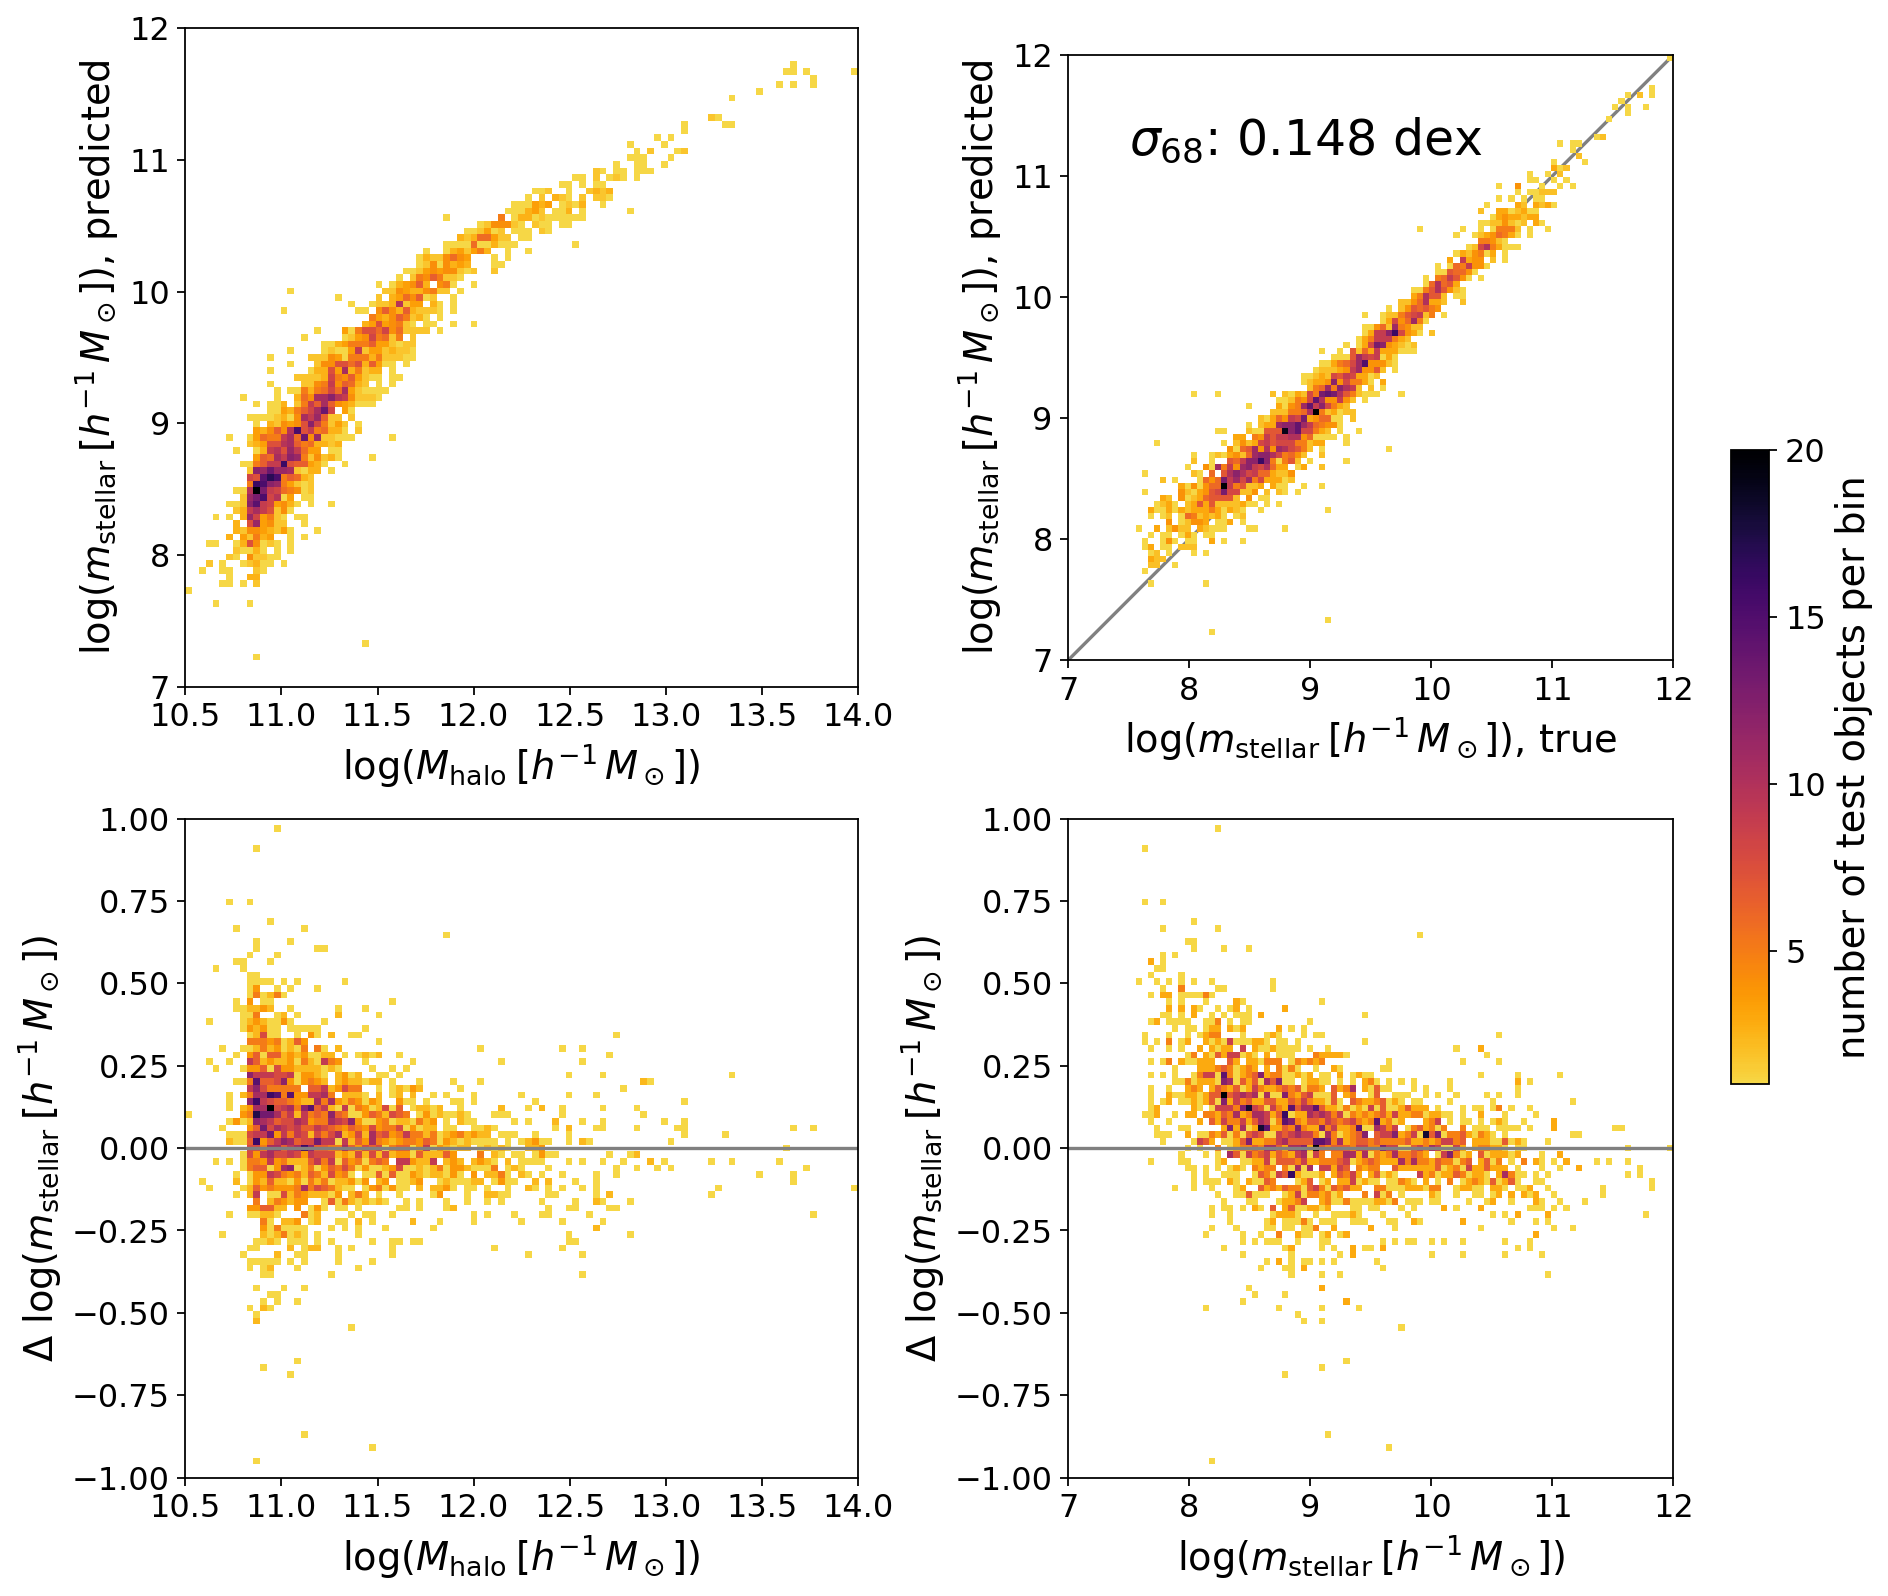

In [68]:
plot_multi_panel_pred(x_label_name, y_label_name, x_property, y_test_mult, y_pred_mult, text_results=error_str,
                               x_lim=(7,12),  y_lim=(7,12))

if savefigs:
    plt.savefig(f'{plot_dir}/pred_mstellar.png', bbox_inches='tight')

# Feature comparison for mstellar

In [77]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'

feature_names = ['mrv', 'catalog', 'geos', 'scalars']
fit_tags = [f'_{y_label_name}_nn_{feature_name}_epochs1000_lr5e-05_hs128' for feature_name in feature_names]

y_pred_arr = []
text_results_arr = []
    
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test] 
y_test_mult = y_test + log_mass_shift

for i, fit_tag in enumerate(fit_tags):
    print(fit_tag)
    
    x = x_dict[feature_names[i]]
    x_extra = x_extra_dict[feature_names[i]]
    if x is not None:
        x_test = x[idx_test]
    else:
        x_test = None
    if x_extra is not None:
        x_test_extra = x_extra[idx_test]
    else:
        x_test_extra = None
        
    fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

    nnfitter = NNFitter()
    nnfitter.load_model(fn_model)

    model_checkpoint = torch.load(fn_model)

    y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

    y_pred_mult = y_pred + log_mass_shift
    
    error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

    
    y_pred_arr.append(y_pred_mult)
    text_results_arr.append(error_str)

_m_stellar_nn_mrv_epochs1000_lr5e-05_hs128
_m_stellar_nn_catalog_epochs1000_lr5e-05_hs128
_m_stellar_nn_geos_epochs1000_lr5e-05_hs128
_m_stellar_nn_scalars_epochs1000_lr5e-05_hs128


In [78]:
def plot_multi_panel_feature(y_label_name, y_true, y_pred_arr,
                      nrows=2, ncols=2, 
                      text_results_arr=[], titles=None, save_fn=None,
                      colorbar_label='', colorbar_fig=None):
    
    fig, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,12))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    inferno_r = matplotlib.cm.inferno_r
    cmap = utils.shiftedColorMap(inferno_r, start=0.1, stop=1.0)
    
    i = 0
    for nr in range(nrows):
        for nc in range(ncols):

            h = plot_pred_vs_true_hist(axarr[nr,nc], y_label_name, y_true, y_pred_arr[i], cmap, 
                                       text_results=text_results_arr[i], colorbar_fig=colorbar_fig,
                                       title=titles[i])
            i += 1
    
    ticks = np.arange(5, 25, 5)
    cax = fig.add_axes([0.93, 0.33, 0.02, 0.33])
    cbar = plt.colorbar(h[3], cax=cax, label='number of test objects per bin', ticks=ticks)
    cbar.ax.set_yticklabels(ticks)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:337: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


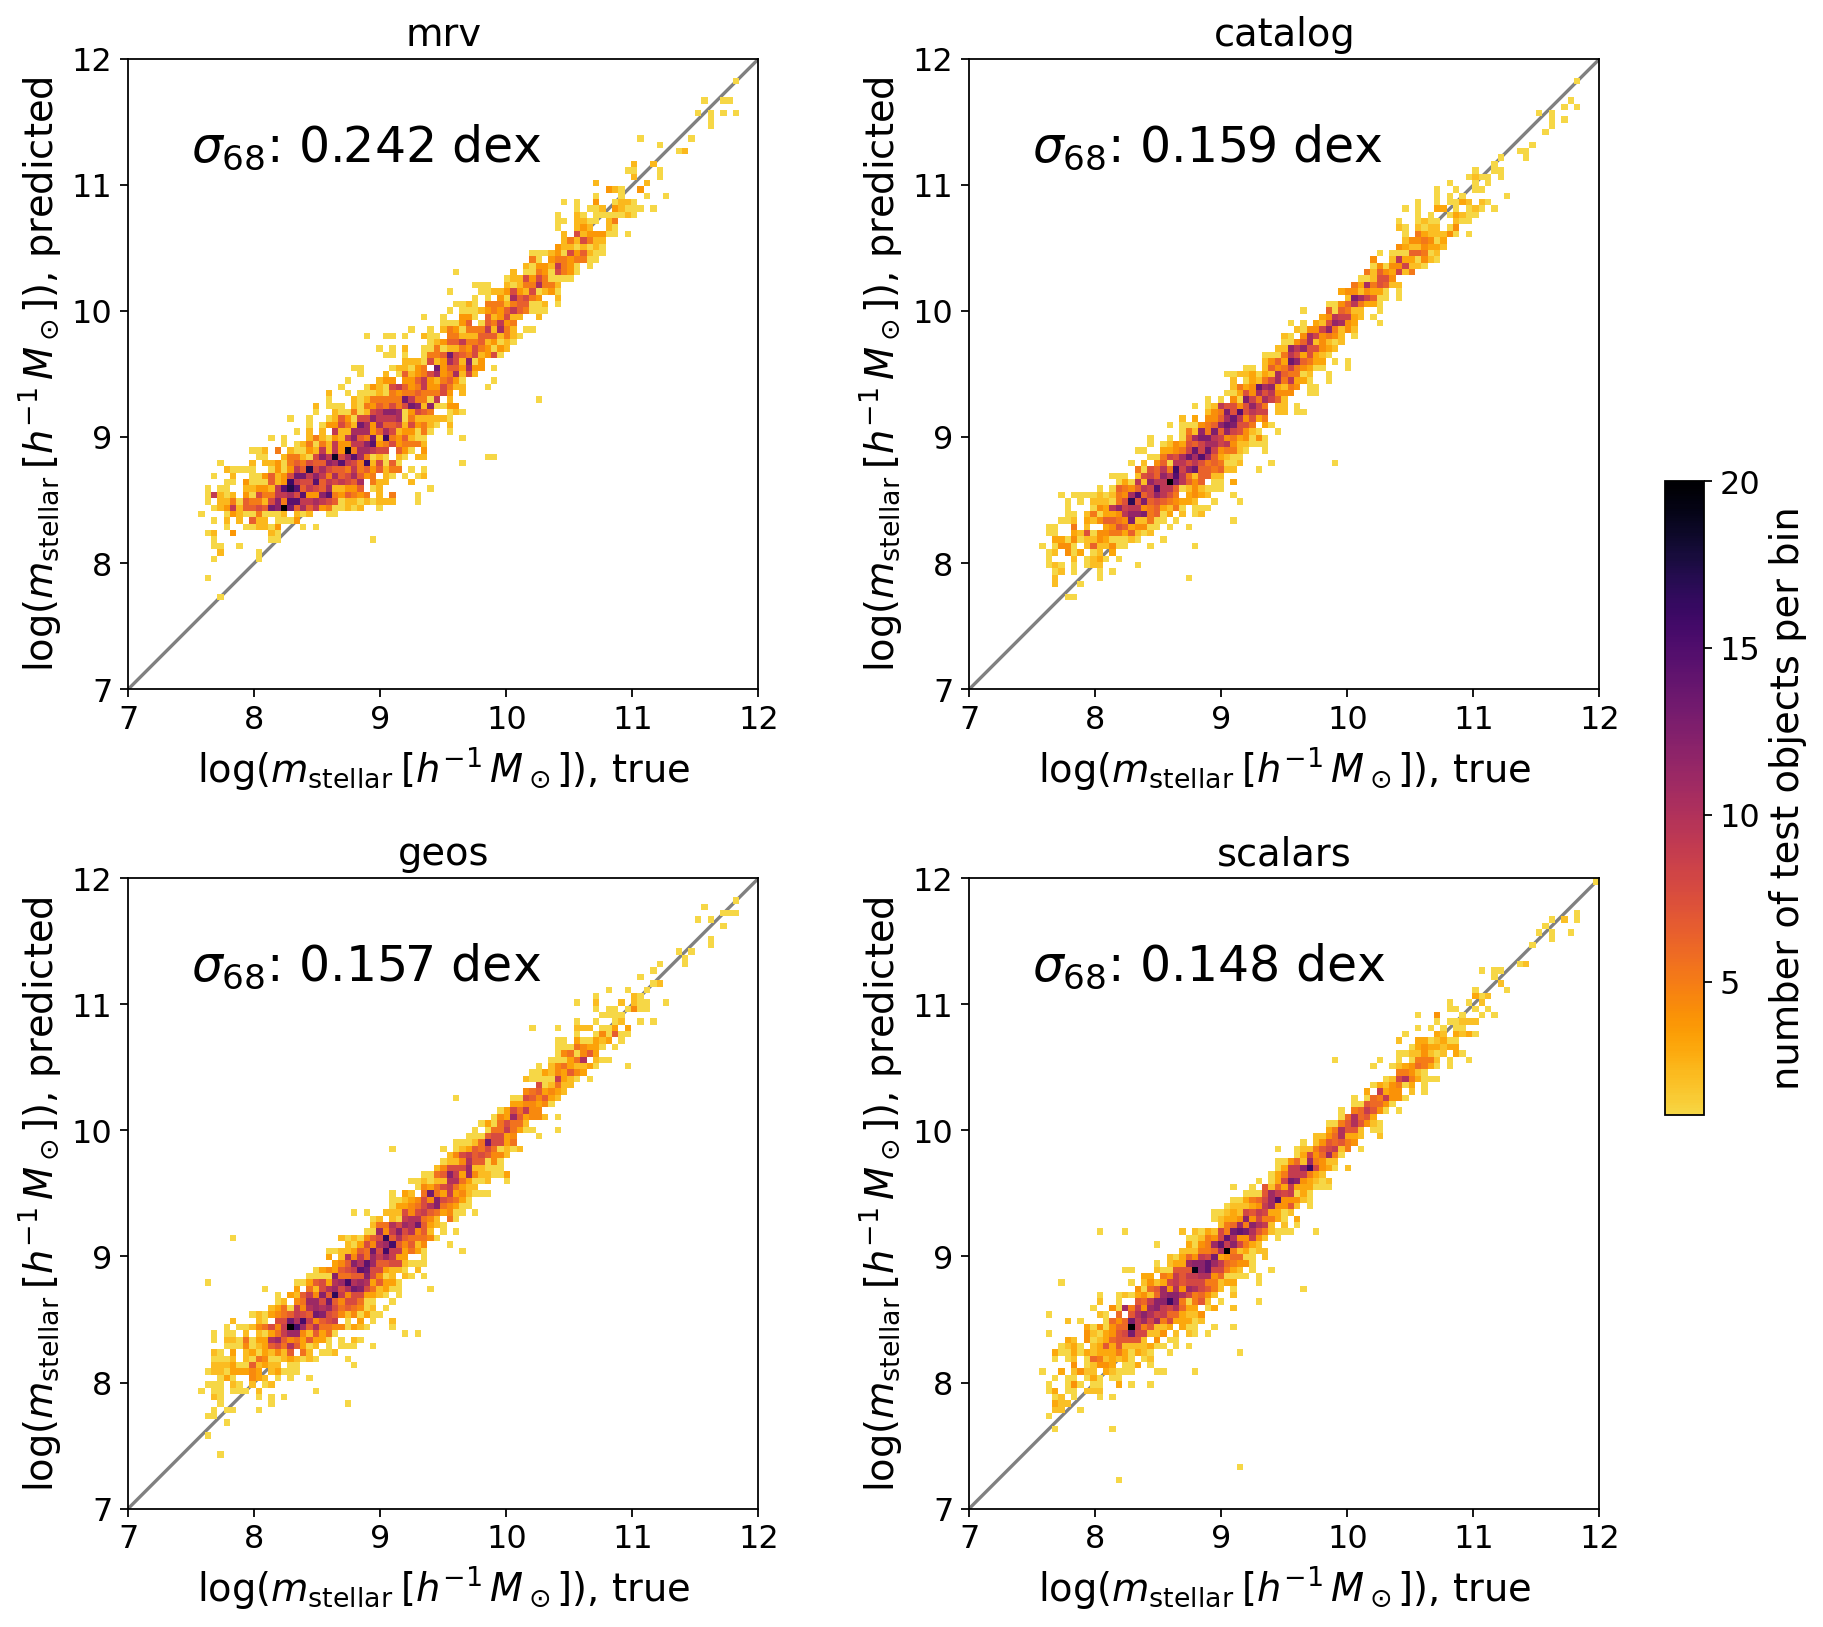

In [79]:
plot_multi_panel_feature(y_label_name, y_test_mult, y_pred_arr, text_results_arr=text_results_arr,
                        titles=feature_names)

if savefigs:
    plt.savefig(f'{plot_dir}/feature_comparison_mstellar.png', bbox_inches='tight')

## Multiple galaxy properies

In [89]:
def plot_multi_panel_gal_props(x_label_name, y_label_name_arr, x_property, y_true_arr, y_pred_arr,
                      text_results_arr=[], title=None, save_fn=None,
                      colorbar_label=''):
    
    nprops = len(y_label_name_arr)
    fig, axarr = plt.subplots(nrows=nprops, ncols=2, figsize=(12, nprops*5),
                              gridspec_kw={'width_ratios': [1, 1.1]})
    plt.subplots_adjust(hspace=0.2, wspace=0.3)
    
    inferno_r = matplotlib.cm.inferno_r
    cmap = utils.shiftedColorMap(inferno_r, start=0.1, stop=1.0)
    
    for i in range(nprops):
        plot_pred_vs_property_hist(axarr[i,0], x_label_name, y_label_name_arr[i], x_property, y_pred_arr[i], 
                                   cmap)

        h = plot_pred_vs_true_hist(axarr[i,1], y_label_name_arr[i], y_true_arr[i], y_pred_arr[i], cmap, 
                                   text_results=text_results_arr[i], colorbar_fig=fig)
    
    
#     ticks = np.arange(5, 25, 5)
#     cax = fig.add_axes([0.93, 0.33, 0.02, 0.33])
#     cbar = plt.colorbar(h[3], cax=cax, label='number of test objects', ticks=ticks)
#     cbar.ax.set_yticklabels(ticks)

In [93]:
x_label_name = 'm_200m'
y_label_name_arr = ['ssfr1', 'r_stellar', 'gband', 'bhmass_per_mstellar', 'j_stellar']
fit_tags = {'ssfr1': '_ssfr1_nn',
            'r_stellar': '_r_stellar_nn',
            'gband': '_gband_nn_scalars_epochs500_lr5e-05_hs128',
            'bhmass_per_mstellar': '_bhmass_per_mstellar_nn_scalars_epochs500_lr5e-05_hs128',
            'j_stellar': '_j_stellar_nn_scalars_epochs500_lr5e-05_hs128',
           }

y_true_arr = []
y_pred_arr = []
text_results_arr = []
    
for y_label_name in y_label_name_arr:
    fit_tag = fit_tags[y_label_name]
    fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

    y = utils.get_y_vals(y_label_name, sim_reader)
    y_test = y[idx_test]

    nnfitter = NNFitter()
    nnfitter.load_model(fn_model)

    model_checkpoint = torch.load(fn_model)

    y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

    y_test_mult = y_test #+ log_mass_shift
    y_pred_mult = y_pred #+ log_mass_shift
    error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
    
    y_true_arr.append(y_test_mult)
    y_pred_arr.append(y_pred_mult)
    text_results_arr.append(error_str)
    
x_property = log_m_200m[idx_test] + log_mass_shift

<KeysViewHDF5 ['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']>


/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:348: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  


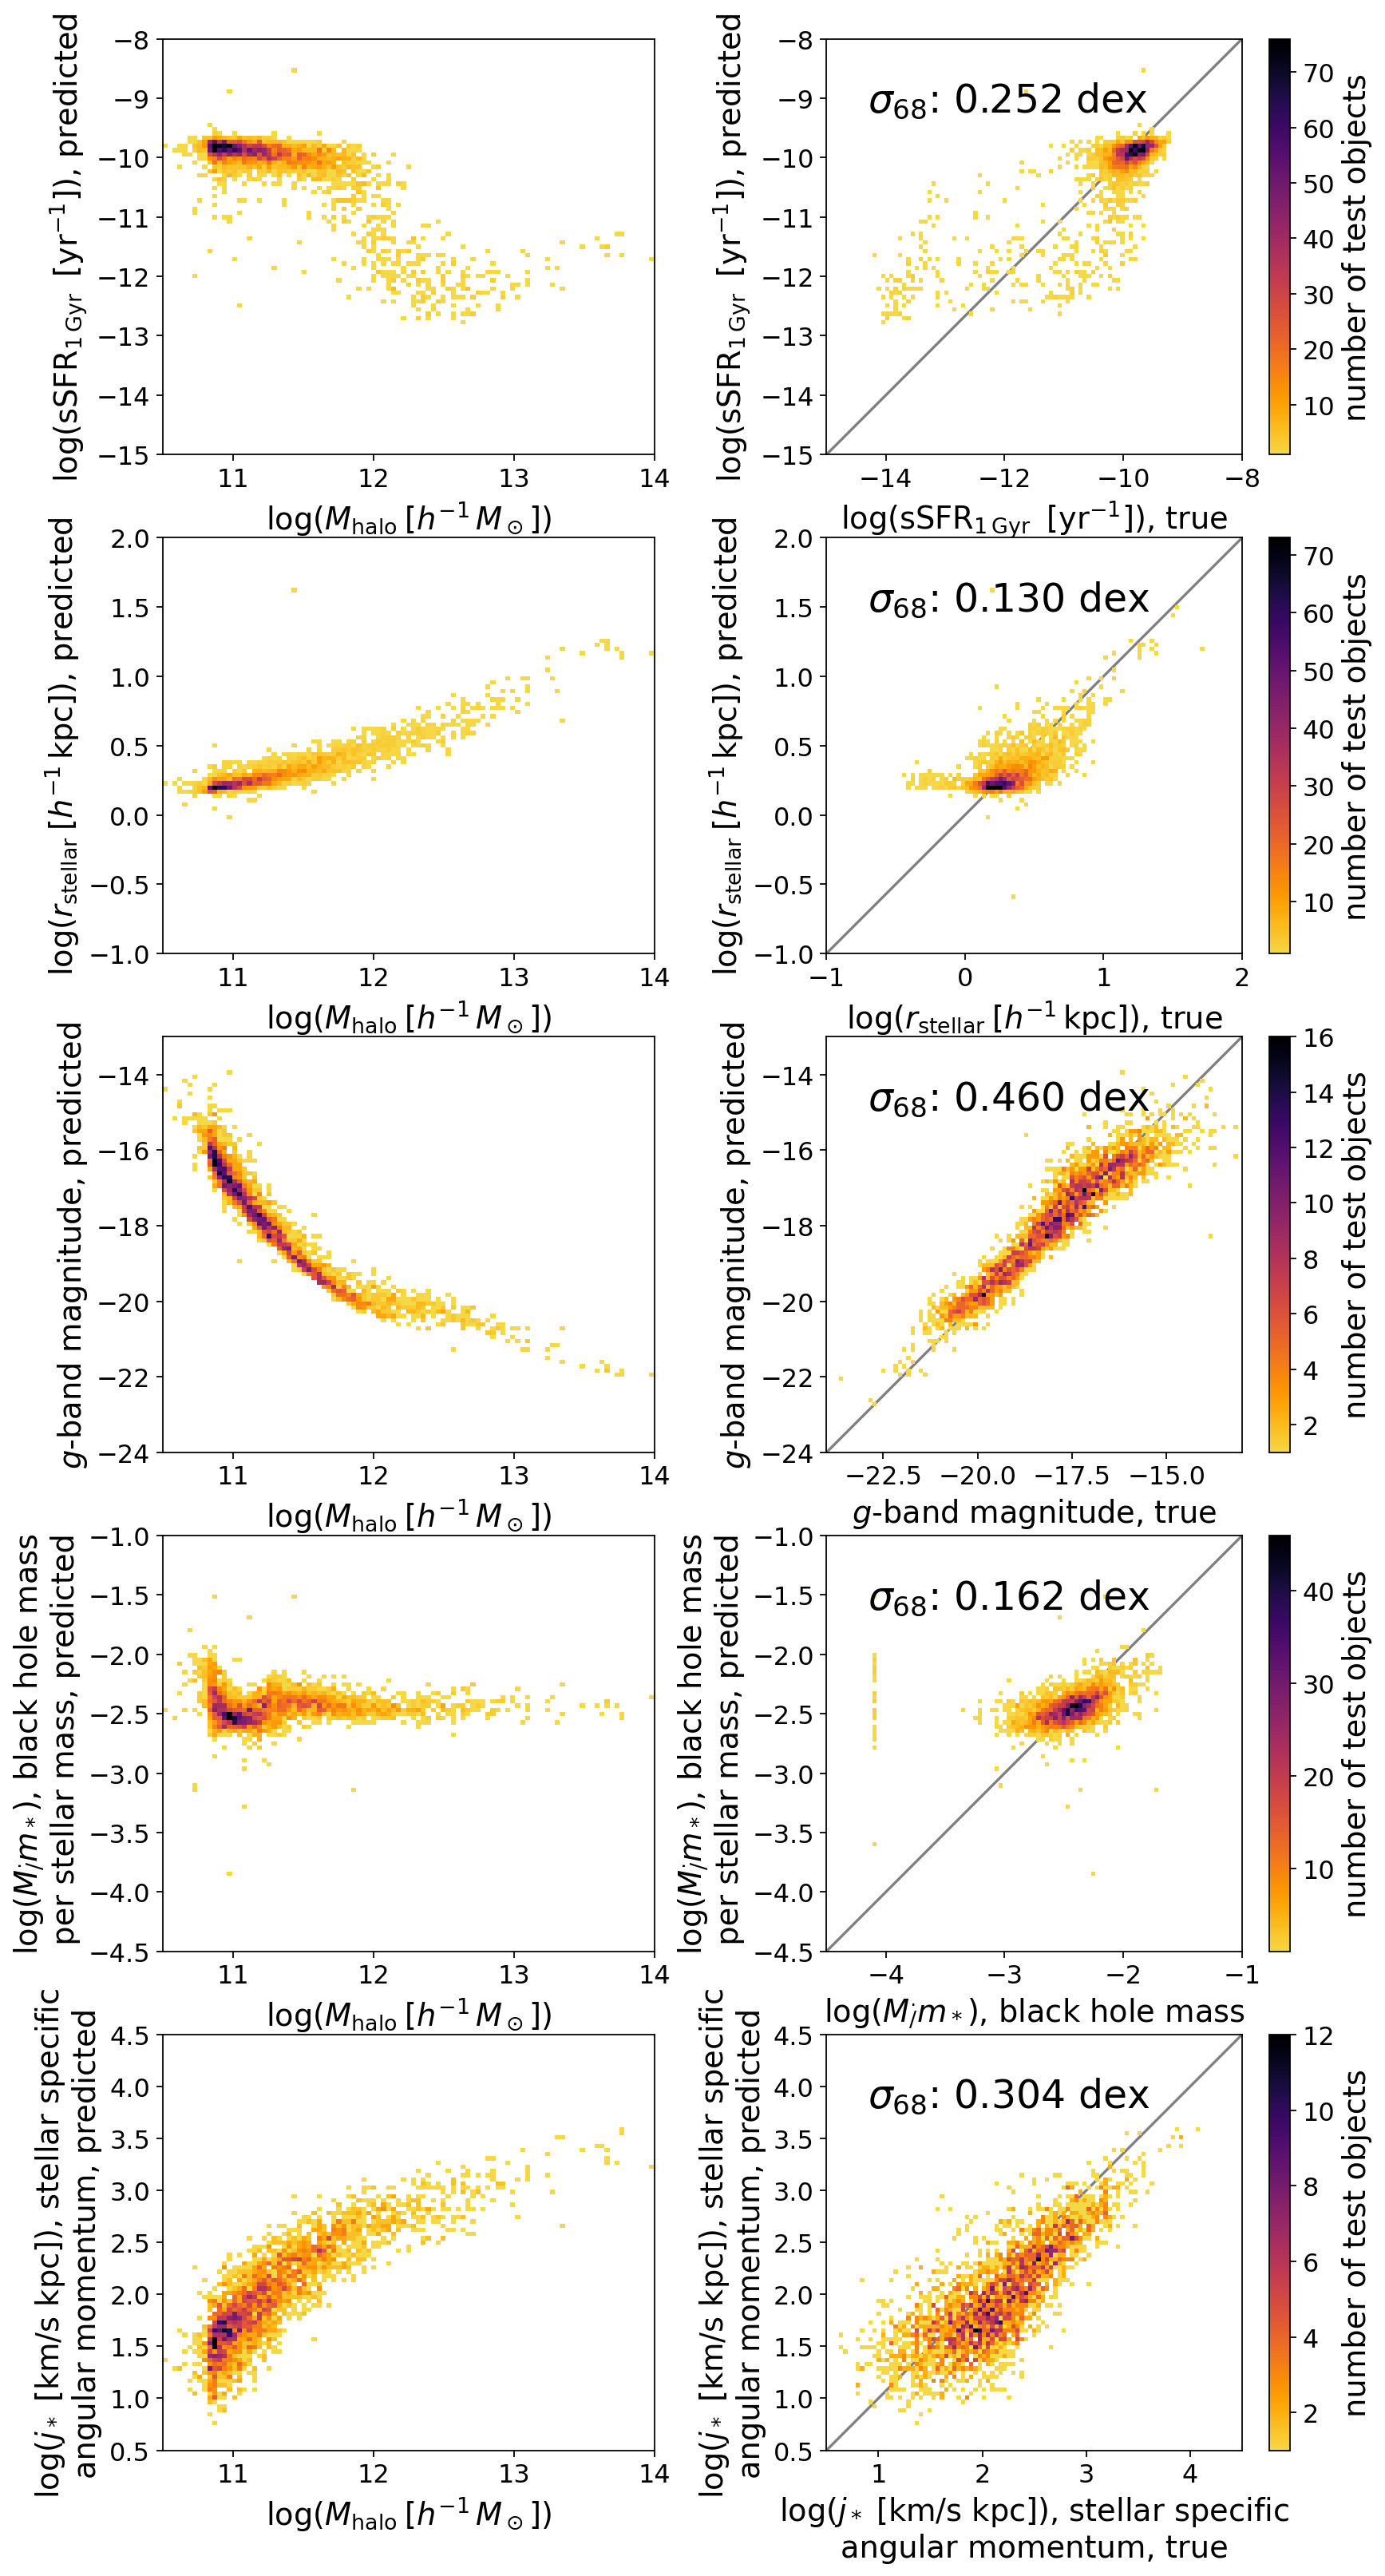

In [100]:
plot_multi_panel_gal_props(x_label_name, y_label_name_arr, x_property, y_true_arr, y_pred_arr,
                      text_results_arr=text_results_arr)

if savefigs:
    plt.savefig(f'{plot_dir}/pred_multi.png', bbox_inches='tight')

# MAH

In [110]:
y_label_name = 'a_mfrac_n39'

In [123]:
y = utils.get_y_vals(y_label_name, sim_reader, halo_tag=halo_tag)
y_test = y[idx_test]

In [124]:
n = y_label_name.split('_n')[-1]
mfrac_vals = utils.get_mfrac_vals(int(n)) # should include 1 or no? now does

In [132]:
fit_tag = f'_{y_label_name}_nn_scalars_epochs2000_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [133]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

In [134]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

In [135]:
def plot_a_mfrac_accuracy(a_pred, a_true, mfracs, title='', n_show=8):
    
    locs_norm = matplotlib.colors.Normalize(vmin=0, vmax=n_show)
    cmap = matplotlib.cm.get_cmap('turbo')
    colors = [cmap(locs_norm(i)) for i in range(n_show)]

    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]},
                                  figsize=(6,8))
    plt.subplots_adjust(hspace=0.03)
    fig.suptitle(title, fontsize=16)

    #errs = (a_pred - a_true)/a_true
    errs = a_pred - a_true

    np.random.seed(14)
    rand_idxs_show = np.random.randint(len(a_true), size=n_show)
    for i, i_rand in enumerate(rand_idxs_show):
        halo = sim_reader.dark_halo_arr[i_rand]
        #a_mah, m_mah = halo.catalog_properties['MAH']
        #plt.plot(a_mah, m_mah/m_mah[0], marker='o', markersize=3, ls='None')

        label_true, label_pred = None, None
        if i==0:
            label_true = 'true value'
            label_pred = 'predicted value'

        ax0.plot(mfracs, a_true[i_rand], marker='o', markersize=4, ls='None', color=colors[i], label=label_true)
        ax0.plot(mfracs, a_pred[i_rand], color=colors[i], label=label_pred)

        ax1.plot(mfracs, errs[i_rand], color=colors[i])

    p16 = np.percentile(errs, 16, axis=0)
    p84 = np.percentile(errs, 84, axis=0)
    sig68_avg = 0.5*(p84-p16)
    ax2.plot(mfracs, p16, color='k', lw=2, label='prediction error')
    ax2.plot(mfracs, p84, color='k', lw=2)
    ax2.axhline(0.0, color='grey', lw=1)

    # print errors
    mfracs_to_print_err = [0.25, 0.5, 0.75]
    errs_to_print = []
    for mfrac in mfracs_to_print_err:
        _, idx_mfrac = utils.find_nearest(mfracs, mfrac)
        errs_to_print.append(rf"$\sigma_{{68}}(M/M_{{a=1}}={mfrac:.2f}) = {sig68_avg[idx_mfrac]:.3f}$")
    
    ax0.text(0.4, 0.1, '\n'.join(errs_to_print), fontsize=14)

    # TODO: this should be based on training set, not test, i think!
    y_test_mean = np.mean(y_test, axis=0)
    #sample_var = (y_test - y_test_mean)/y_test_mean
    sample_var = (y_test - y_test_mean)
    sample_p16 = np.percentile(sample_var, 16, axis=0)
    sample_p84 = np.percentile(sample_var, 84, axis=0)
    ax2.fill_between(mfracs, sample_p16, sample_p84, color='blue', lw=2, alpha=0.3, label='sample variance')

    ax0.set_ylabel(r'$a$, scale factor')
    #ax1.set_ylabel(r'$(a_\mathrm{pred}-a_\mathrm{true})/a_\mathrm{true}$')
    ax1.set_ylabel(r'$a_\mathrm{pred}-a_\mathrm{true}$')
    ax2.set_ylabel(r'$\sigma_{68}$')

    ax2.set_xlabel(r'$M_\mathrm{vir}(a)$/$M_\mathrm{vir}(a=1)$ of most massive progenitor halo')

    ax0.set_ylim(0,1)
    ax1.axhline(0.0, color='grey', lw=1)
    ax2.set_ylim(-0.2, 0.2)
    
    ax0.legend(fontsize=12, loc='upper left')
    ax2.legend(fontsize=12, loc='lower left')

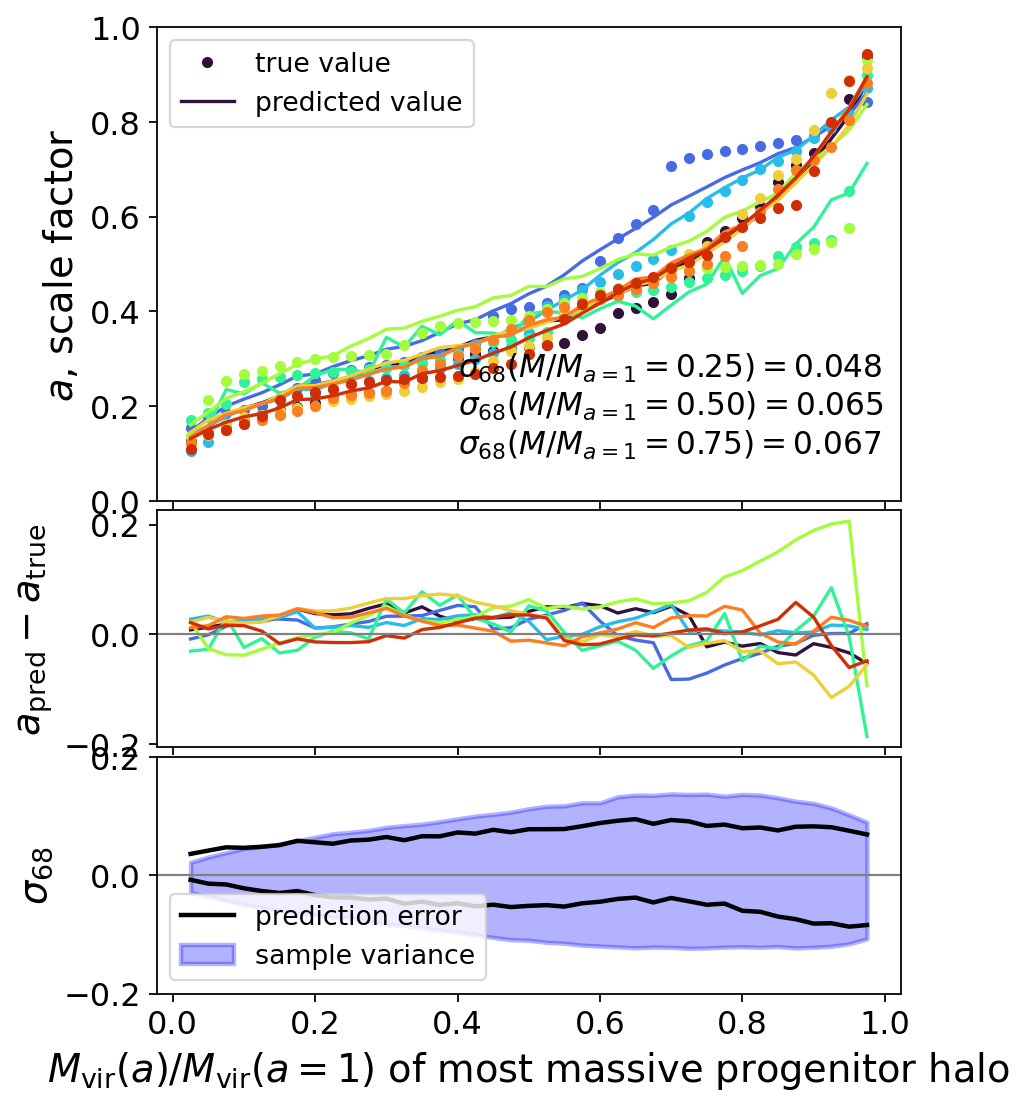

In [138]:
plot_a_mfrac_accuracy(y_pred, y_test, mfrac_vals, title='', n_show=8)

if savefigs:
    plt.savefig(f'{plot_dir}/pred_mah.png', bbox_inches='tight')